# Modelo RandomForest

En este JN voy a desarrollar y entrenar mi modelo, obteniendo las principales métricas tanto de las base de datos como del propio modelo, para terminar guardándolo y así poder utilizarlo para realizar predicciones de nuevos sonidos.

De todas formas, en JN voy a aplicarle al modelo PCA para saber si existe alguna mejora alternativa que le pueda aplicar a mi modelo.

Empiezo importando las librerías que voy a utilizar.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

A continuación he creado 3 funciones que me dan lo siguiente:
 - La primera me lee el dataset sobre el que voy a trabajar.
 - La segunda me muestra las principales métricas y características de la base de datos.
 - Y la tercera crea dos gráficos, el primero es una correlation matrix entre las diferentes features del dataset, y el segundo me muestra la relación entre cada una de las features y cómo es esta relación y su distribución.

In [39]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [14]:
def show_df_info(dataframe):
    display("The type of the dataframe is {}.".format(type(dataframe)))
    print("------------------------------------------------------------------------")
    display("The amount of entries are {}.".format(dataframe.size))
    print("------------------------------------------------------------------------")
    display("Its shape is {}.".format(dataframe.shape))
    print("------------------------------------------------------------------------")
    display("Its features are: {}.".format(list(dataframe)))
    print("------------------------------------------------------------------------")
    print("The data types of columns are: {}".format(dataframe.dtypes))
    print("------------------------------------------------------------------------")
    print("The counter of each class is: {}".format(dataframe.momento.value_counts()))
    print("------------------------------------------------------------------------")
    print('The amount of null values is: {}.'.format(dataframe.isna().sum()))
    display(dataframe.head())
    display(dataframe.describe())
    
show_df_info(data)

"The type of the dataframe is <class 'pandas.core.frame.DataFrame'>."

------------------------------------------------------------------------


'The amount of entries are 572360.'

------------------------------------------------------------------------


'Its shape is (14309, 40).'

------------------------------------------------------------------------


"Its features are: ['mfcc', 'scem', 'scom', 'srom', 'sbwm', 'tempo', 'rmse', 'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10', 'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15', 'Fourier16', 'Fourier17', 'Fourier18', 'Fourier19', 'Fourier20', 'Fourier21', 'Fourier22', 'Fourier23', 'Fourier24', 'Fourier25', 'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 'Fourier30', 'Fourier31', 'Fourier32', 'momento']."

------------------------------------------------------------------------
The data types of columns are: mfcc         float64
scem         float64
scom         float64
srom         float64
sbwm         float64
tempo        float64
rmse         float64
Fourier1     float64
Fourier2     float64
Fourier3     float64
Fourier4     float64
Fourier5     float64
Fourier6     float64
Fourier7     float64
Fourier8     float64
Fourier9     float64
Fourier10    float64
Fourier11    float64
Fourier12    float64
Fourier13    float64
Fourier14    float64
Fourier15    float64
Fourier16    float64
Fourier17    float64
Fourier18    float64
Fourier19    float64
Fourier20    float64
Fourier21    float64
Fourier22    float64
Fourier23    float64
Fourier24    float64
Fourier25    float64
Fourier26    float64
Fourier27    float64
Fourier28    float64
Fourier29    float64
Fourier30    float64
Fourier31    float64
Fourier32    float64
momento       object
dtype: object
------------------------------------------

,mfcc,scem,scom,srom,sbwm,tempo,rmse,Fourier1,Fourier2,Fourier3,...,Fourier24,Fourier25,Fourier26,Fourier27,Fourier28,Fourier29,Fourier30,Fourier31,Fourier32,momento
0,-19.602940,1016.689071,28.116497,1344.604492,526.793735,117.187500,0.082146,0.009263,0.012996,0.012584,...,0.006196,0.007697,0.008855,0.012467,0.022492,0.063204,0.154885,0.012584,0.012996,Timbre
1,-23.112227,1361.218925,25.115322,2646.606445,1025.292241,117.187500,0.055449,0.091122,0.116129,0.504887,...,0.284429,0.137750,0.123100,0.141838,0.087461,0.039865,0.118851,0.504887,0.116129,Cena
2,4.153023,662.289054,21.617422,1497.436523,832.083155,156.250000,0.240111,5.745226,4.179618,0.842350,...,0.145524,0.233634,0.307225,0.486006,0.661933,0.242134,0.867832,0.842350,4.179618,Lavadora
3,-15.240392,1539.737568,22.446293,2865.844727,1002.431942,133.928571,0.113920,0.667184,0.231604,0.799329,...,0.379264,0.510500,0.445284,0.477069,0.804105,0.829143,1.475118,0.799329,0.231604,Secador_pelo
4,6.963927,582.127562,19.931546,1348.144531,798.607193,133.928571,0.212797,2.974887,0.945422,0.571051,...,0.152262,0.090392,0.157818,0.212591,0.090181,0.243442,0.554560,0.571051,0.945422,Aire_acondicionado


,mfcc,scem,scom,srom,sbwm,tempo,rmse,Fourier1,Fourier2,Fourier3,...,Fourier23,Fourier24,Fourier25,Fourier26,Fourier27,Fourier28,Fourier29,Fourier30,Fourier31,Fourier32
count,14309.000000,14309.000000,14309.000000,14309.000000,14309.000000,14309.000000,1.430900e+04,1.430900e+04,1.430900e+04,1.430900e+04,...,1.430900e+04,14309.000000,14309.000000,1.430900e+04,14309.000000,1.430900e+04,14309.000000,1.430900e+04,1.430900e+04,1.430900e+04
mean,-8.971953,1254.151396,22.267809,2249.303162,892.667099,130.348089,8.841907e-02,9.235651e-01,8.207713e-01,6.463853e-01,...,1.471023e-01,0.151666,0.167978,2.257706e-01,0.236699,2.674153e-01,0.323432,4.386883e-01,6.463853e-01,8.207713e-01
std,10.089162,554.546872,3.258389,810.205158,197.193087,19.883178,8.043133e-02,1.799353e+00,1.226849e+00,1.373220e+00,...,1.939466e-01,0.202599,0.245692,3.550661e-01,0.330550,3.885057e-01,0.462326,5.672125e-01,1.373220e+00,1.226849e+00
min,-56.459336,168.275230,1.698515,291.992188,101.931160,37.500000,5.919943e-08,5.073782e-07,5.302750e-07,9.490217e-07,...,8.521026e-07,0.000001,0.000001,5.838372e-07,0.000002,8.068922e-07,0.000001,6.708018e-07,9.490217e-07,5.302750e-07
25%,-16.452749,798.831594,19.927511,1515.258789,805.112993,117.187500,1.969259e-02,3.763595e-02,5.440067e-02,4.146728e-02,...,2.184711e-02,0.023131,0.025481,2.781803e-02,0.034783,3.334841e-02,0.032738,3.284250e-02,4.146728e-02,5.440067e-02
50%,-7.939312,1280.946945,21.832554,2380.004883,927.216385,133.928571,6.710561e-02,1.933344e-01,2.683205e-01,2.511623e-01,...,7.997130e-02,0.085392,0.095736,1.109115e-01,0.126726,1.272525e-01,0.151234,2.159520e-01,2.511623e-01,2.683205e-01
75%,-3.015536,1738.380026,23.659746,2838.134766,1038.395741,133.928571,1.351235e-01,8.397143e-01,1.068091e+00,7.669710e-01,...,1.926018e-01,0.204286,0.222277,2.617446e-01,0.303950,3.426385e-01,0.432991,6.334587e-01,7.669710e-01,1.068091e+00
max,8.775053,2707.461116,51.275412,3609.375000,1299.501746,312.500000,5.108476e-01,1.580141e+01,1.147088e+01,1.399953e+01,...,1.733549e+00,2.803029,4.165502,3.959535e+00,3.784848,3.763040e+00,5.427896,5.434906e+00,1.399953e+01,1.147088e+01


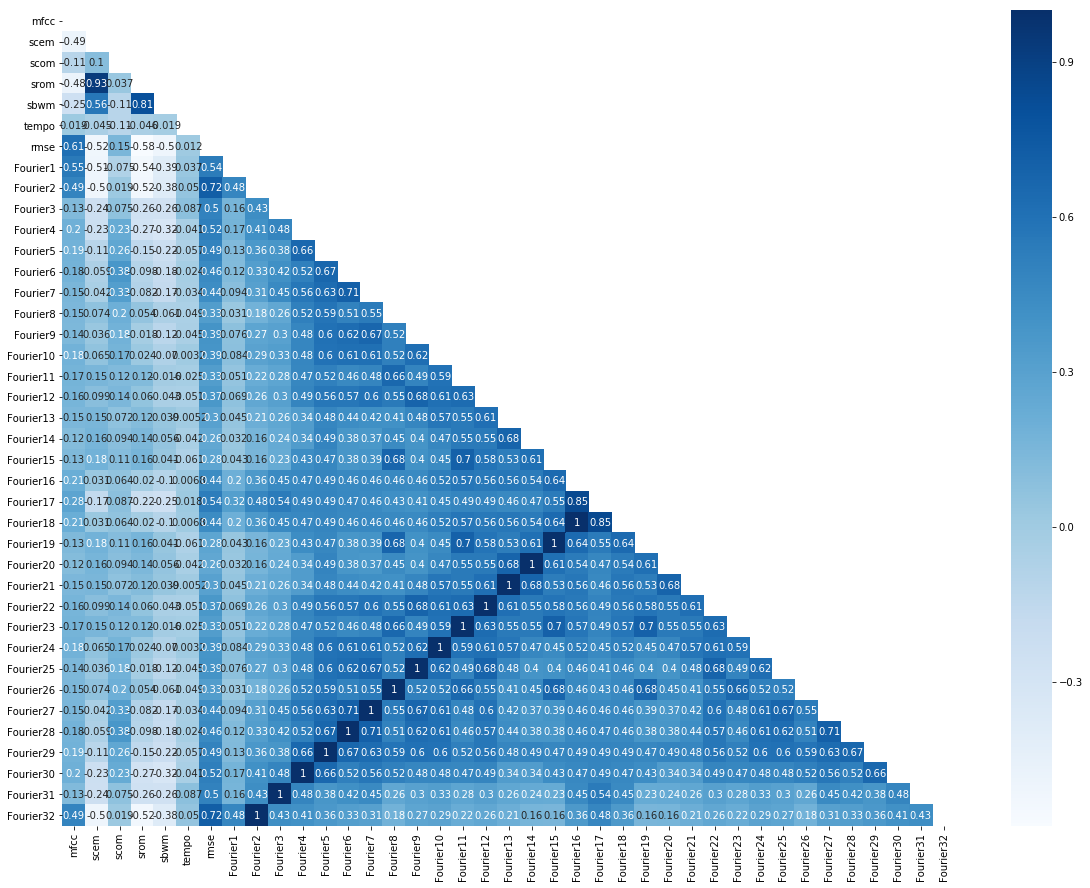

In [15]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(data, 'momento')

Debido a la alta correlación entre la primera y la segunda mitad de las features, elimino las segundas dado que no me aportan prácticamente ningún valor.

A continuación muestro la matriz de correlación para ver que la correlación entre las features restantes entra dentro de lo normal.

In [16]:
data = data.drop(['Fourier18', 'Fourier19', 'Fourier20', 'Fourier21', 'Fourier22', 'Fourier23', 'Fourier24', 
                  'Fourier25', 'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 'Fourier30',
                  'Fourier31', 'Fourier32'], axis=1)

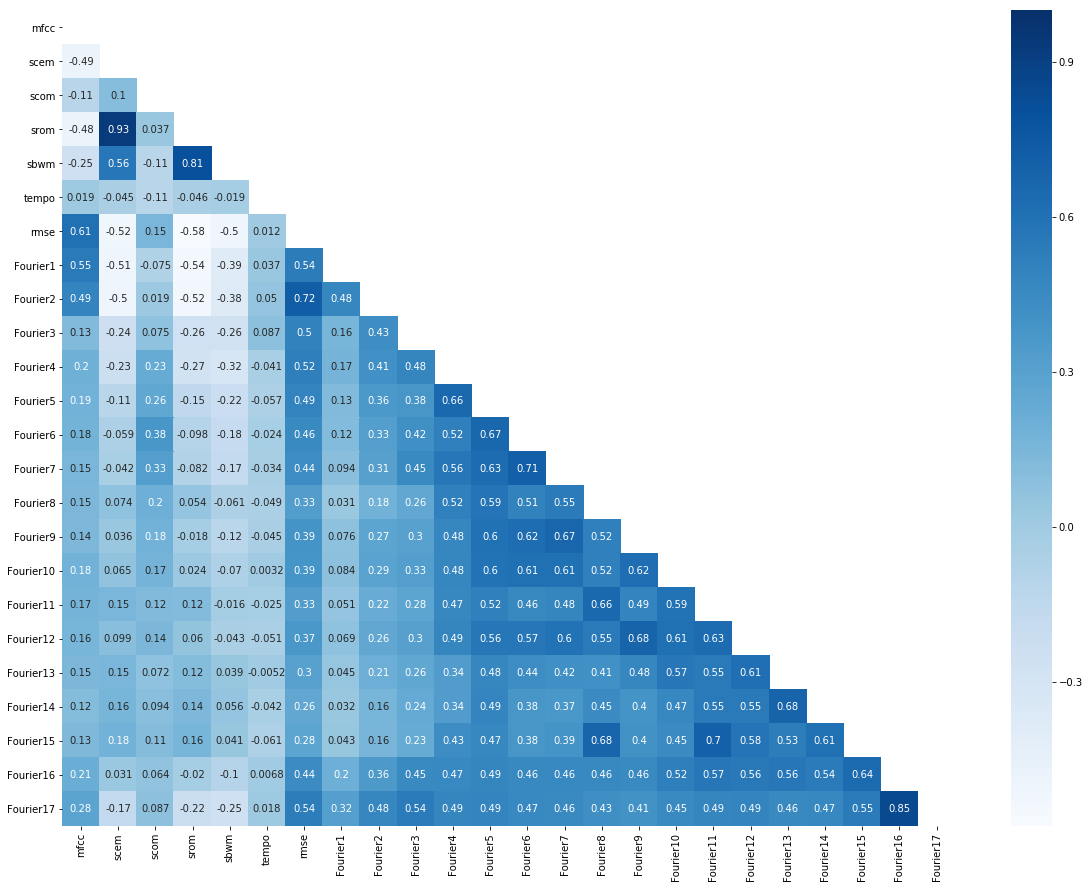

In [17]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(data, 'momento')

# Modelo

A partir de este momento es cuando empiezo a preparar y entrenar el modelo.

La dinámica es la que hemos seguido siempre, por lo que no voy a entrar en detalles que ya todos conocemos. Simplemente me limitaré a comentar los resultados y a epxlicar código que no haya sido utilizado previamente.

In [18]:
y = pd.get_dummies(data=data.momento)
X = data.loc[:, data.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [19]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(model, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.96925227 0.97554158 0.97484277 0.97763802 0.96296296 0.97484277
 0.97134871 0.97344514 0.97204752 0.96713287]
Accuracy: 0.97 (+/- 0.01)


A la luz del accuracy anterior y del score del modelo, se puede ver claramente que se trata de un modelo con gran capacidad predictiva.

In [20]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.976240391334731

Con el siguiente código guardo mi modelo ya entrenado para poder utilizarlo a la hora de realizar predicciones, ahorrando así cálculos y tiempo.

In [21]:
filename = 'finalized_model_fourier.sav'
pickle.dump(model, open(filename, 'wb'))

Como podemos observar, los errores son bastante pequeños, lo cual era algo de esperar.

In [22]:
predictions = model.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.01
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.00
Licuadora             0.01
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


A continuación, dado que para este tipo de modelos no podemos aplicar un OLS para saber cómo de relevante es cada feature en nuestro modelo, he aplicado otra función llamada 'feature_importances_' que me permite obtener la relevancia de cada feature.

De todas formas, esta función ni funciona si al modelo le aplico un OneVsRestClassifier() como he hecho antes, por lo que se los que quitado con el fin de obtener al menos un cálculo estimado. De todas formas, no sé si es la forma correcta de proceder en este caso.

Como podemos ver en los resultados, todas las features tienen cierta relevancia, por lo que deshecho una idea que tenía en la cabeza que era la de eliminar o bien la feature 'srom' o bien 'scem', debido a la alta correlación entre ellos. Pero dado que ambas tiene una importancia relevante en el modelo, he decidido no deshacerme de ninguna de las dos.

In [23]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_
cls.score(X_test, y_test)

0.9849755415793152

In [24]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.153798)
2. feature 1 (0.122559)
3. feature 0 (0.116126)
4. feature 3 (0.113226)
5. feature 4 (0.112697)
6. feature 6 (0.107215)
7. feature 10 (0.031991)
8. feature 8 (0.024317)
9. feature 14 (0.023323)
10. feature 9 (0.022588)
11. feature 13 (0.022034)
12. feature 7 (0.016640)
13. feature 12 (0.016267)
14. feature 15 (0.015444)
15. feature 17 (0.015093)
16. feature 11 (0.013368)
17. feature 21 (0.012882)
18. feature 18 (0.012380)
19. feature 16 (0.011166)
20. feature 19 (0.010439)
21. feature 20 (0.008546)
22. feature 5 (0.007751)
23. feature 22 (0.007018)
24. feature 23 (0.003133)


,importance
scom,0.153798
scem,0.122559
mfcc,0.116126
srom,0.113226
sbwm,0.112697
rmse,0.107215
Fourier4,0.031991
Fourier2,0.024317
Fourier8,0.023323
Fourier3,0.022588


Y a continuación complemento un poco más en análisis anterior y muestro también la desviación estandar de cada feature, juntos con su importancia.

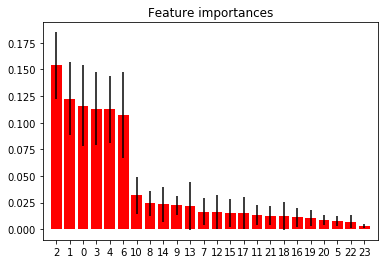

In [25]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Sin entrar mucho más en detalle, podemos continuar corroborando que el modelo falla muy poco a la hora de predecir, como se puede observar en los siguientes scores.

In [26]:
actual_values = y_test.values.argmax(axis=1)
predictions = model.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9769392033542977

In [27]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9768931598705626

In [28]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento'
precision_recall

,precision,recall,f1_score
momento,,,
Cena,0.739837,1.000000,0.850467
Ducha,0.994709,1.000000,0.997347
Lavadora,1.000000,0.988950,0.994444
Aspiradora,1.000000,0.909091,0.952381
Afeitadora,1.000000,0.978261,0.989011
Secador_pelo,1.000000,0.994565,0.997275
Aire_acondicionado,1.000000,0.981595,0.990712
Telefono,1.000000,0.996000,0.997996
Tecleo,1.000000,0.910000,0.952880


Como se va a poder ver en el gráfico de debajo, el modelo ha fallado muy poco prediciendo, sobre todo con la clase 'Licuadora', que a veces las clasifica como 'Afeitadora' debido a la similitud de ambos sonidos.

Confusion matrix, without normalization
[[182   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 188   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0 179   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 15   0   0 150   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0 135   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0 183   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0 160   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0 249   0   0   0   0   0   0   0   0]
 [ 17   0   0   0   0   0   0   0 182   0   0   0   0   1   0   0]
 [  2   0   0   0   0   0   0   0   0 200   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 165   0   0   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0   0 206   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 168   0   0   0]
 [  6   0   0   0   0   0   0   0   0   0   0   0   0 191   0   0]
 [  1   0   0   0   0 

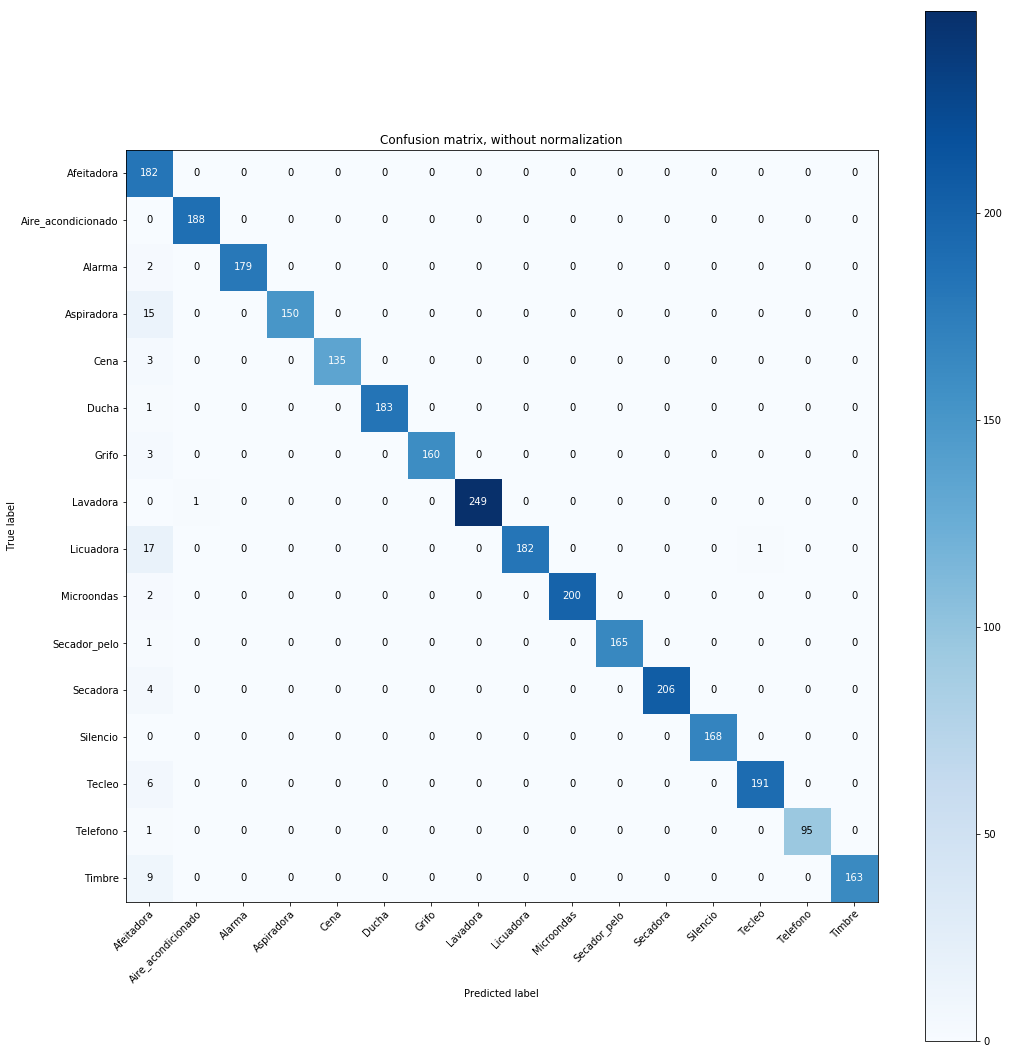

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

Y para terminar con el análisis de nuestro modelo, calculamos y graficamos las ROC Curves. Y como se ve en los resultados, el AUC para cada una de las clases es casi siempre del 100%.

Por lo que finalmente podemos conclir que tenemos un modelo bastante bueno y predictivo.

In [30]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [32]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [33]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [35]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [36]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [37]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

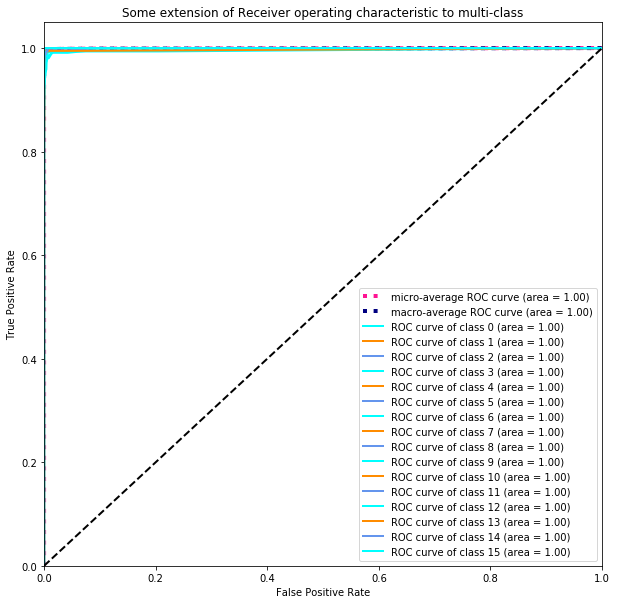

In [38]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()